# Basic Analysis: Paris Intra-Muros

**Master's Thesis: Detecting and Validating Gentrification in Paris**

This notebook provides a baseline analysis of four open datasets (IRIS, DVF, SIRENE, OSM) for Paris intra-muros (department 75, INSEE code 75056). The goal is to understand data coverage, timeframes, counts, and produce basic visualizations.

---

## 0 — Setup

Import required libraries and define helper functions for data exploration.

In [1]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from pyrosm import OSM
from shapely.geometry import Point

# Create outputs folder
os.makedirs('outputs', exist_ok=True)

print("Libraries imported successfully.")

Libraries imported successfully.


Define a helper function to display the temporal coverage of each dataset.

In [2]:
def timeframe(series, name):
    """
    Print the minimum and maximum dates in a datetime series.
    
    Parameters:
    - series: pandas Series of datetime values
    - name: str, name of the dataset/field
    """
    valid = series.dropna()
    if len(valid) > 0:
        print(f"{name}: {valid.min()} to {valid.max()}")
    else:
        print(f"{name}: No valid dates found")

Load IRIS administrative zones and filter for Paris intra-muros only.

In [3]:
import geopandas as gpd
iris = gpd.read_file("data/iris.geojson")
print(iris.columns)
iris.head(3)

Index(['dep', 'insee_com', 'nom_com', 'iris', 'code_iris', 'nom_iris',
       'typ_iris', 'geo_point_2d', 'id', 'geometry'],
      dtype='object')


,dep,insee_com,nom_com,iris,code_iris,nom_iris,typ_iris,geo_point_2d,id,geometry
0,92,92048,Meudon,0101,920480101,Meudon la Forêt 1,H,"{ ""lon"": 2.2328125762019511, ""lat"": 48.7862406...",IRIS____0000000920480101,"POLYGON ((2.23637 48.78878, 2.23585 48.78827, ..."
1,91,91657,Vigneux-sur-Seine,0101,916570101,Pasteur-Place Marx Dormoy-La Longueraie,H,"{ ""lon"": 2.425941608784842, ""lat"": 48.71587327...",IRIS____0000000916570101,"POLYGON ((2.43972 48.72534, 2.4407 48.72419, 2..."
2,78,78217,Épône,0102,782170102,Épône Centre Bourg,H,"{ ""lon"": 1.817194475410002, ""lat"": 48.95490370...",IRIS____0000000782170102,"POLYGON ((1.79413 48.94722, 1.79397 48.94737, ..."


In [4]:
iris[iris["dep"] == "75"].shape

(992, 10)

In [5]:
# --- Load IRIS data ---
iris = gpd.read_file("data/iris.geojson")

print(f"Total IRIS zones loaded: {len(iris)}")
print(f"Original CRS: {iris.crs}")
print(f"Columns: {iris.columns.tolist()[:10]}")

# --- Filter for Paris (department 75) ---
iris["dep"] = iris["dep"].astype(str).str.strip()
iris_paris75 = iris[iris["dep"] == "75"].copy()

print(f"IRIS zones in Paris: {len(iris_paris75)}")

# --- Save filtered IRIS ---
iris_paris75.to_file("outputs/iris_paris75.geojson", driver="GeoJSON")
print("✓ Saved outputs/iris_paris.geojson")

Total IRIS zones loaded: 5264
Original CRS: EPSG:4326
Columns: ['dep', 'insee_com', 'nom_com', 'iris', 'code_iris', 'nom_iris', 'typ_iris', 'geo_point_2d', 'id', 'geometry']
IRIS zones in Paris: 992
✓ Saved outputs/iris_paris.geojson


---

## 1 — IRIS Overview

Visualize the IRIS zones that define Paris intra-muros administrative boundaries.

In [6]:
print(f"CRS: {iris_paris75.crs}")
print(f"Number of IRIS zones in Paris: {len(iris_paris75)}")
print(f"\nColumn names: {list(iris_paris75.columns)}")

CRS: EPSG:4326
Number of IRIS zones in Paris: 992

Column names: ['dep', 'insee_com', 'nom_com', 'iris', 'code_iris', 'nom_iris', 'typ_iris', 'geo_point_2d', 'id', 'geometry']


Plot the boundary map of Paris IRIS zones.

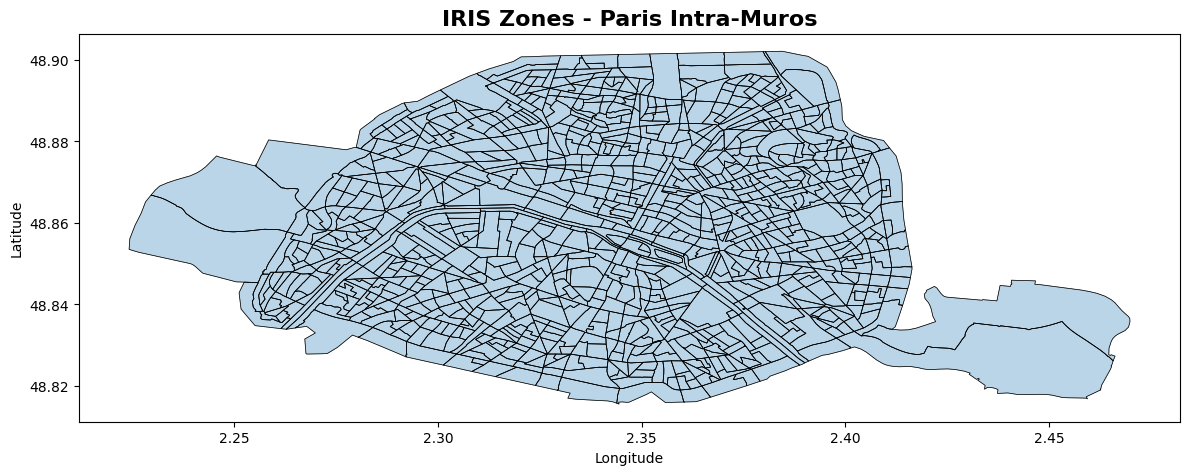

✓ Saved outputs/fig_iris_paris75.png


In [7]:
fig, ax = plt.subplots(figsize=(12, 10))
iris_paris75.boundary.plot(ax=ax, linewidth=0.5, edgecolor='black')
iris_paris75.plot(ax=ax, alpha=0.3, edgecolor='black', linewidth=0.5)
ax.set_title('IRIS Zones - Paris Intra-Muros', fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_aspect('equal')
plt.tight_layout()
plt.savefig('outputs/fig_iris_paris75.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved outputs/fig_iris_paris75.png")

---

## 2 — DVF Analysis

DVF (Demandes de Valeurs Foncières) contains real estate transaction data. We'll analyze price trends and transaction volumes in Paris.

Load DVF data from the GeoPackage file.

In [8]:
# Load DVF data
dvf = gpd.read_file('data/DVF mutations_d75.gpkg')

print(f"Total DVF records loaded: {len(dvf):,}")
print(f"CRS: {dvf.crs}")
print(f"\nColumn names: {list(dvf.columns)[:20]}...")  # Show first 20 columns

/usr/local/python/3.12.1/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'DVF mutations_d75.gpkg': 'mutation_geompar' (default), 'mutation_geomparmut', 'mutation_geomlocmut'. Specify layer parameter to avoid this warning.
  result = read_func(


Total DVF records loaded: 457,097
CRS: EPSG:2154

Column names: ['idmutation', 'idmutinvar', 'idopendata', 'idnatmut', 'codservch', 'refdoc', 'datemut', 'anneemut', 'moismut', 'coddep', 'libnatmut', 'vefa', 'valeurfonc', 'nbdispo', 'nblot', 'nbcomm', 'l_codinsee', 'nbsection', 'l_section', 'nbpar']...


Convert date field to datetime and examine temporal coverage.

In [9]:
# Convert date to datetime
dvf['datemut'] = pd.to_datetime(dvf['datemut'], errors='coerce')

# Print timeframe
timeframe(dvf['datemut'], "DVF transactions")

DVF transactions: 2014-01-02 00:00:00 to 2024-12-31 00:00:00


Perform spatial join to keep only transactions within Paris IRIS boundaries.

In [10]:
# Reproject IRIS to Lambert 93 (EPSG:2154) for spatial operations
iris_paris_2154 = iris_paris75.to_crs(epsg=2154)

# Ensure DVF is in EPSG:2154
if dvf.crs.to_epsg() != 2154:
    dvf = dvf.to_crs(epsg=2154)

# Spatial join to filter transactions in Paris
dvf_paris75 = gpd.sjoin(dvf, iris_paris_2154[['geometry']], how='inner', predicate='within')

print(f"DVF records in Paris: {len(dvf_paris75):,}")
print(f"Percentage of records in Paris: {len(dvf_paris75)/len(dvf)*100:.1f}%")

DVF records in Paris: 453,086
Percentage of records in Paris: 99.1%


Save filtered DVF data for Paris.

In [11]:
dvf_paris75.to_parquet("outputs/dvf_paris75.parquet", index=False)
print("✓ Saved outputs/dvf_paris.parquet")

✓ Saved outputs/dvf_paris.parquet


Calculate price per square meter where data is available.

In [12]:
# Compute price per m²
mask = (dvf_paris75['valeurfonc'].notna()) & (dvf_paris75['sbati'].notna()) & (dvf_paris75['sbati'] > 0)
dvf_paris75.loc[mask, 'price_m2'] = dvf_paris75.loc[mask, 'valeurfonc'] / dvf_paris75.loc[mask, 'sbati']

print(f"Records with price/m² calculated: {mask.sum():,}")
print(f"\nPrice/m² statistics:")
print(dvf_paris75['price_m2'].describe())

Records with price/m² calculated: 388,269

Price/m² statistics:
count    3.882690e+05
mean     9.492701e+03
std      8.160958e+03
min      0.000000e+00
25%      7.407407e+03
50%      9.300909e+03
75%      1.125000e+04
max      1.900000e+06
Name: price_m2, dtype: float64


Visualize median price per square meter evolution over time.

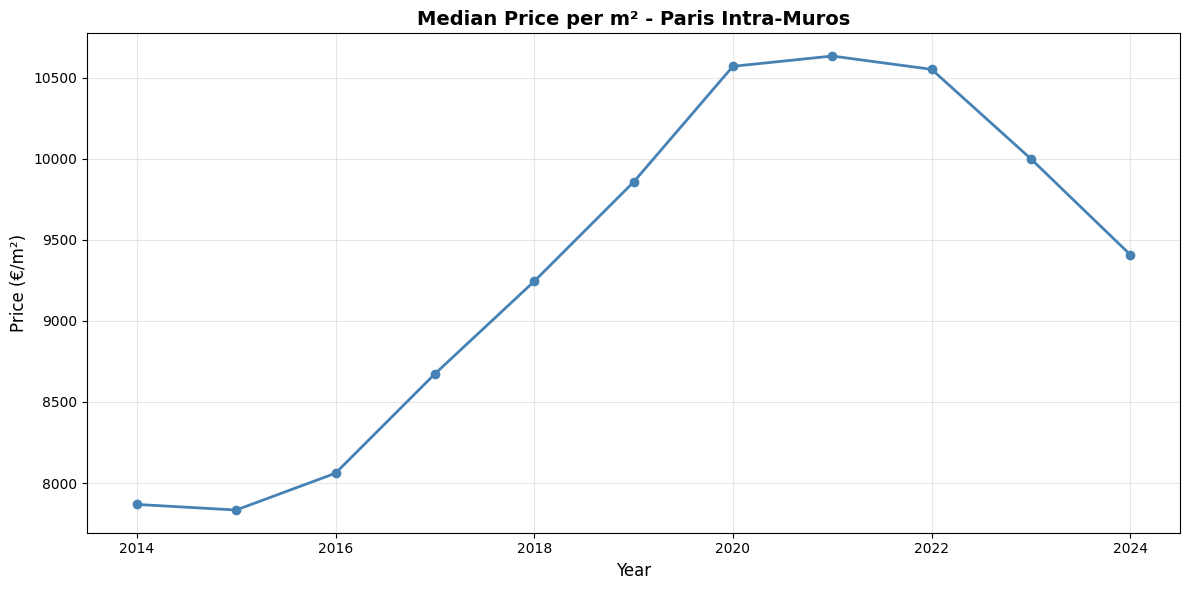

✓ Saved outputs/fig_dvf_price_year.png


In [13]:
# Extract year from transaction date
dvf_paris75['year'] = dvf_paris75['datemut'].dt.year

# Calculate median price/m² per year
price_per_year = dvf_paris75.groupby('year')['price_m2'].median().dropna()

# Plot median price/m² per year
fig, ax = plt.subplots(figsize=(12, 6))
price_per_year.plot(ax=ax, marker='o', linewidth=2, markersize=6, color='steelblue')
ax.set_title('Median Price per m² - Paris Intra-Muros', fontsize=14, fontweight='bold')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Price (€/m²)', fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('outputs/fig_dvf_price_year.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved outputs/fig_dvf_price_year.png")

Analyze transaction volume by year.

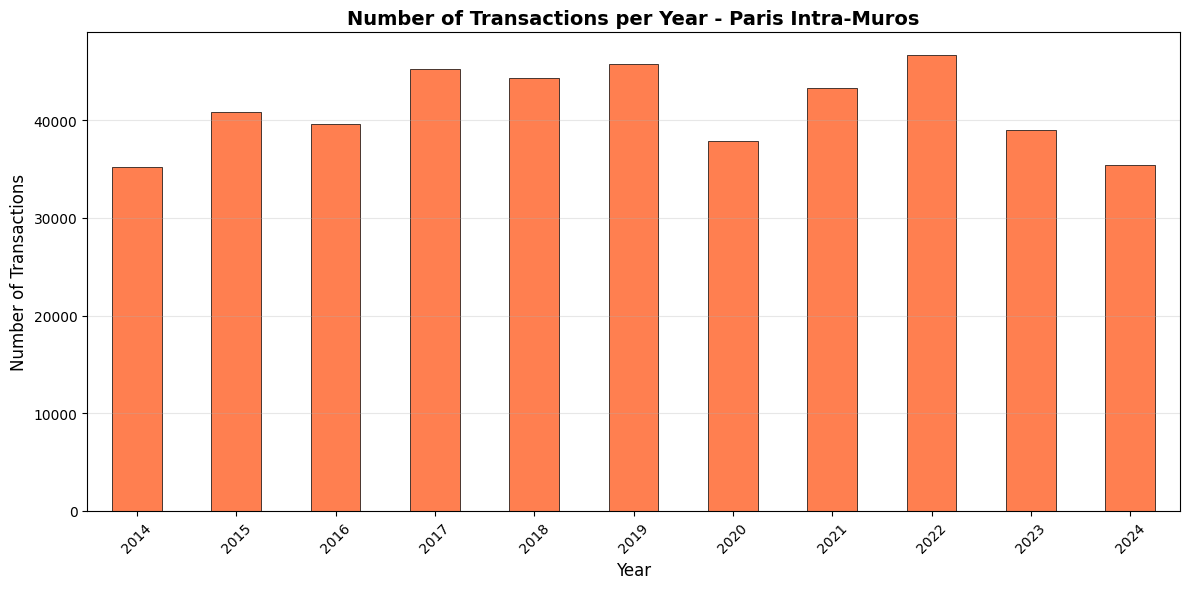

✓ Saved outputs/fig_dvf_transactions_year.png


In [14]:
# Count transactions per year
transactions_per_year = dvf_paris75.groupby('year').size()

# Plot number of transactions per year
fig, ax = plt.subplots(figsize=(12, 6))
transactions_per_year.plot(kind='bar', ax=ax, color='coral', edgecolor='black', linewidth=0.5)
ax.set_title('Number of Transactions per Year - Paris Intra-Muros', fontsize=14, fontweight='bold')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of Transactions', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('outputs/fig_dvf_transactions_year.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved outputs/fig_dvf_transactions_year.png")

---

## 3 — SIRENE Analysis

SIRENE contains data on business establishments. We'll analyze establishment creation trends in Paris.

Load SIRENE data with selected columns only for efficiency.

In [ ]:
import os
import pyarrow as pa
import pyarrow.dataset as ds
import pyarrow.parquet as pq

# --- Colonnes utiles ---
sirene_cols = [
    "siret",
    "dateCreationEtablissement",
    "codeCommuneEtablissement",
    "codePostalEtablissement",
    "coordonneeLambertAbscisseEtablissement",
    "coordonneeLambertOrdonneeEtablissement",
    "etatAdministratifEtablissement",
    "activitePrincipaleEtablissement",
]

# --- Dataset source ---
sirene_path = "data/StockEtablissement_utf8.parquet"
dataset = ds.dataset(sirene_path, format="parquet")

# --- Filtre Paris (INSEE 75056 OU CP 75000–75999) ---
f = (
    (ds.field("codeCommuneEtablissement") == "75056") |
    ((ds.field("codePostalEtablissement") >= "75000") &
     (ds.field("codePostalEtablissement") <= "75999"))
)

# --- Scanner en streaming (pas de pandas) ---
scanner = ds.Scanner.from_dataset(
    dataset,
    columns=sirene_cols,
    filter=f,
    use_threads=True,
    batch_size=100_000,  # ajuste si besoin
)

# --- Écriture incrémentale vers un fichier parquet filtré ---
os.makedirs("outputs", exist_ok=True)
out_path = "outputs/sirene_paris75.parquet"
writer = None
total_rows = 0

for batch in scanner.to_batches():
    table = pa.Table.from_batches([batch])
    total_rows += table.num_rows
    if writer is None:
        writer = pq.ParquetWriter(out_path, table.schema, compression="zstd")
    writer.write_table(table)

if writer is not None:
    writer.close()

# --- Vérification rapide ---
pf = pq.ParquetFile(out_path)
print(f"✓ Écrit: {out_path}")
print("Row groups:", pf.num_row_groups)
print("Rows (counted during stream):", total_rows)
print("Rows (from metadata):", pf.metadata.num_rows)

✓ Écrit: outputs/sirene_paris75.parquet
Row groups: 675
Rows (counted during stream): 3177473
Rows (from metadata): 3177473


: 

Filter for Paris establishments using commune code and postal code.

In [ ]:
# Filter for Paris (commune code 75056 or postal code starting with 75)
mask_commune = sirene['codeCommuneEtablissement'] == '75056'
mask_postal = sirene['codePostalEtablissement'].astype(str).str.startswith('75')

sirene_paris = sirene[mask_commune | mask_postal].copy()

print(f"SIRENE records in Paris: {len(sirene_paris):,}")
print(f"Percentage in Paris: {len(sirene_paris)/len(sirene)*100:.1f}%")

Convert creation date to datetime and examine temporal coverage.

In [ ]:
# Convert date to datetime
sirene_paris['dateCreationEtablissement'] = pd.to_datetime(
    sirene_paris['dateCreationEtablissement'], 
    errors='coerce'
)

# Print timeframe
timeframe(sirene_paris['dateCreationEtablissement'], "SIRENE establishment creation")

Create geometries from Lambert coordinates and perform spatial join with IRIS.

In [ ]:
# Filter records with valid coordinates
mask_coords = (
    sirene_paris['coordonneeLambertAbscisseEtablissement'].notna() & 
    sirene_paris['coordonneeLambertOrdonneeEtablissement'].notna()
)

sirene_paris_coords = sirene_paris[mask_coords].copy()

print(f"Records with valid Lambert coordinates: {len(sirene_paris_coords):,}")

# Create geometry from Lambert coordinates
geometry = [
    Point(xy) for xy in zip(
        sirene_paris_coords['coordonneeLambertAbscisseEtablissement'],
        sirene_paris_coords['coordonneeLambertOrdonneeEtablissement']
    )
]

sirene_paris_gdf = gpd.GeoDataFrame(
    sirene_paris_coords, 
    geometry=geometry, 
    crs='EPSG:2154'
)

print(f"GeoDataFrame created with CRS: {sirene_paris_gdf.crs}")

Spatial join with IRIS to confirm establishments are within Paris boundaries.

In [ ]:
# Spatial join with IRIS Paris
sirene_paris_final = gpd.sjoin(
    sirene_paris_gdf, 
    iris_paris_2154[['geometry']], 
    how='inner', 
    predicate='within'
)

print(f"SIRENE records within Paris IRIS: {len(sirene_paris_final):,}")

Count new establishments created per year.

In [ ]:
# Extract year from creation date
sirene_paris_final['year'] = sirene_paris_final['dateCreationEtablissement'].dt.year

# Count new establishments per year
establishments_per_year = sirene_paris_final.groupby('year').size()

print(f"\nEstablishments created per year (sample):")
print(establishments_per_year.tail(10))

Visualize establishment creation trends over time.

In [ ]:
# Plot establishments per year
fig, ax = plt.subplots(figsize=(14, 6))
establishments_per_year.plot(kind='bar', ax=ax, color='mediumseagreen', edgecolor='black', linewidth=0.5)
ax.set_title('New Establishments per Year - Paris Intra-Muros', fontsize=14, fontweight='bold')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of New Establishments', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('outputs/fig_sirene_new_year.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved outputs/fig_sirene_new_year.png")

Save filtered SIRENE data for Paris.

In [ ]:
# Drop spatial index column and save
sirene_paris_save = sirene_paris_final.drop(columns=['index_right', 'geometry'], errors='ignore')
sirene_paris_save.to_parquet('outputs/sirene_paris.parquet', index=False)
print("✓ Saved outputs/sirene_paris.parquet")

---

## 4 — OSM Analysis

OpenStreetMap data provides information on urban amenities and buildings. We'll extract and visualize points of interest in Paris.

Load OSM data using PyROSM and create a Paris boundary for clipping.

In [ ]:
# Load OSM data
osm = OSM('data/ile-de-france-250916.osm.pbf')

# Create Paris boundary (union of all IRIS polygons)
paris_boundary = iris_paris75.unary_union

print("OSM data loaded successfully")
print(f"Paris boundary type: {type(paris_boundary)}")

Extract points of interest (POIs) such as amenities, shops, leisure, and tourism features.

In [ ]:
# Extract POIs (amenity, shop, leisure, tourism)
pois = osm.get_pois()

if pois is not None:
    print(f"Total POIs extracted: {len(pois):,}")
    print(f"POI CRS: {pois.crs}")
    
    # Clip to Paris boundary
    pois_paris = pois[pois.intersects(paris_boundary)].copy()
    
    print(f"POIs within Paris: {len(pois_paris):,}")
    
    # Display available amenity types
    if 'amenity' in pois_paris.columns:
        print(f"\nTop 10 amenity types:")
        print(pois_paris['amenity'].value_counts().head(10))
else:
    print("No POIs found in the OSM file")
    pois_paris = None

Extract building footprints from OSM data.

In [ ]:
# Extract buildings
buildings = osm.get_buildings()

if buildings is not None:
    print(f"Total buildings extracted: {len(buildings):,}")
    print(f"Buildings CRS: {buildings.crs}")
    
    # Clip to Paris boundary
    buildings_paris = buildings[buildings.intersects(paris_boundary)].copy()
    
    print(f"Buildings within Paris: {len(buildings_paris):,}")
else:
    print("No buildings found in the OSM file")
    buildings_paris = None

Visualize amenity points within Paris intra-muros.

In [ ]:
if pois_paris is not None and len(pois_paris) > 0:
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Plot Paris boundary
    iris_paris75.boundary.plot(ax=ax, linewidth=1, edgecolor='black', alpha=0.5)
    
    # Plot amenities
    pois_paris.plot(ax=ax, markersize=1, color='red', alpha=0.3)
    
    ax.set_title('OSM Amenities - Paris Intra-Muros', fontsize=16, fontweight='bold')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.savefig('outputs/fig_osm_amenities.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Saved outputs/fig_osm_amenities.png")
else:
    print("Cannot create amenity map - no POI data available")

Save extracted OSM data (amenities and buildings) for Paris.

In [ ]:
# Save amenities
if pois_paris is not None and len(pois_paris) > 0:
    # Convert to DataFrame (drop geometry for parquet efficiency)
    pois_paris_df = pd.DataFrame(pois_paris.drop(columns='geometry', errors='ignore'))
    pois_paris_df.to_parquet('outputs/osm_paris_amenities.parquet', index=False)
    print("✓ Saved outputs/osm_paris_amenities.parquet")
else:
    print("No amenities to save")

# Save buildings
if buildings_paris is not None and len(buildings_paris) > 0:
    buildings_paris_df = pd.DataFrame(buildings_paris.drop(columns='geometry', errors='ignore'))
    buildings_paris_df.to_parquet('outputs/osm_paris_buildings.parquet', index=False)
    print("✓ Saved outputs/osm_paris_buildings.parquet")
else:
    print("No buildings to save")

---

## 5 — Summary

Comprehensive overview of all datasets processed for Paris intra-muros.

In [ ]:
print("=" * 80)
print("DATASET SUMMARY - PARIS INTRA-MUROS")
print("=" * 80)

# IRIS
print("\n1. IRIS (Administrative Zones)")
print(f"   CRS: {iris_paris75.crs}")
print(f"   Timeframe: N/A (administrative boundaries)")
print(f"   Total zones: {len(iris_paris75)}")
print(f"   Output: outputs/iris_paris75.geojson")
print(f"   Figure: outputs/fig_iris_paris75.png")

# DVF
print("\n2. DVF (Real Estate Transactions)")
print(f"   CRS: EPSG:2154 (Lambert 93)")
timeframe(dvf_paris['datemut'], "   Timeframe")
print(f"   Records (total): {len(dvf):,}")
print(f"   Records (Paris): {len(dvf_paris):,}")
print(f"   Output: outputs/dvf_paris.parquet")
print(f"   Figures: outputs/fig_dvf_price_year.png, outputs/fig_dvf_transactions_year.png")

# SIRENE
print("\n3. SIRENE (Business Establishments)")
print(f"   CRS: EPSG:2154 (Lambert 93)")
timeframe(sirene_paris_final['dateCreationEtablissement'], "   Timeframe")
print(f"   Records (total): {len(sirene):,}")
print(f"   Records (Paris): {len(sirene_paris_final):,}")
print(f"   Output: outputs/sirene_paris.parquet")
print(f"   Figure: outputs/fig_sirene_new_year.png")

# OSM
print("\n4. OSM (OpenStreetMap)")
print(f"   CRS: EPSG:4326 (WGS84)")
print(f"   Timeframe: 2025-09-16 (extract date)")
if pois_paris is not None:
    print(f"   Amenities (Paris): {len(pois_paris):,}")
else:
    print(f"   Amenities (Paris): 0")
if buildings_paris is not None:
    print(f"   Buildings (Paris): {len(buildings_paris):,}")
else:
    print(f"   Buildings (Paris): 0")
print(f"   Outputs: outputs/osm_paris_amenities.parquet, outputs/osm_paris_buildings.parquet")
print(f"   Figure: outputs/fig_osm_amenities.png")

print("\n" + "=" * 80)
print("Analysis complete. All filtered datasets and figures saved in outputs/ folder.")
print("=" * 80)